In [73]:
from herbie import Herbie
from toolbox import EasyMap, pc
import cartopy.crs as ccrs
import cartopy.feature as cfeature  # Importing feature module
from cartopy.feature import NaturalEarthFeature  # Importing NaturalEarthFeature
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from datetime import datetime, timedelta
from matplotlib.colors import LinearSegmentedColormap
import numpy as np  # Importing numpy for unique function
from scipy.ndimage import zoom

In [63]:
# Data Checker - Lists available data for the current date and hourly run you choose

available_fxx = []

# Loop through potential forecast hours
for fxx in range(0, 30, 6):  # Assuming potential forecast hours from 0 to 47
    try:
        H_temp = Herbie(
            init_date.strftime("%Y-%m-%d %H"),
            model="ecmwf",
            product="oper",
            fxx=fxx
        )
        
        # Attempt to retrieve the data
        ds = H_temp.xarray(":2t:")
        
        # Check if valid_time has duplicates and deduplicate if necessary
        if 'valid_time' in ds.coords and ds['valid_time'].size > 1:
            _, index = np.unique(ds['valid_time'], return_index=True)
            ds = ds.isel(valid_time=index)
        
        # If successful, add the current fxx to the list
        available_fxx.append(fxx)
    except:
        # If there's an error (likely data not found), break out of the loop
        break

fxx_range = available_fxx
print(ds)

✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-16 12:00 UTC F00 ┊ GRIB2 @ azure ┊ IDX @ azure
✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-16 12:00 UTC F06 ┊ GRIB2 @ azure ┊ IDX @ azure
✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-16 12:00 UTC F12 ┊ GRIB2 @ azure ┊ IDX @ azure
✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-16 12:00 UTC F18 ┊ GRIB2 @ azure ┊ IDX @ azure
✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-16 12:00 UTC F24 ┊ GRIB2 @ azure ┊ IDX @ azure
<xarray.Dataset>
Dimensions:              (latitude: 451, longitude: 900)
Coordinates:
    time                 datetime64[ns] 2023-10-16T12:00:00
    step                 timedelta64[ns] 1 days
    heightAboveGround    float64 2.0
  * latitude             (latitude) float64 90.0 89.6 89.2 ... -89.2 -89.6 -90.0
  * longitude            (longitude) float64 -180.0 -179.6 ... 179.2 179.6
    valid_time           datetime64[ns] 2023-10-17T12:00:00
Data variables:
    t2m                  (latitude, longitude) float32 253.2 

✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-16 12:00 UTC F00 ┊ GRIB2 @ azure ┊ IDX @ azure
✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-16 12:00 UTC F00 ┊ GRIB2 @ azure ┊ IDX @ azure
✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-16 12:00 UTC F06 ┊ GRIB2 @ azure ┊ IDX @ azure
✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-16 12:00 UTC F12 ┊ GRIB2 @ azure ┊ IDX @ azure
✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-16 12:00 UTC F18 ┊ GRIB2 @ azure ┊ IDX @ azure
✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-16 12:00 UTC F24 ┊ GRIB2 @ azure ┊ IDX @ azure


✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-16 12:00 UTC F00 ┊ GRIB2 @ azure ┊ IDX @ azure


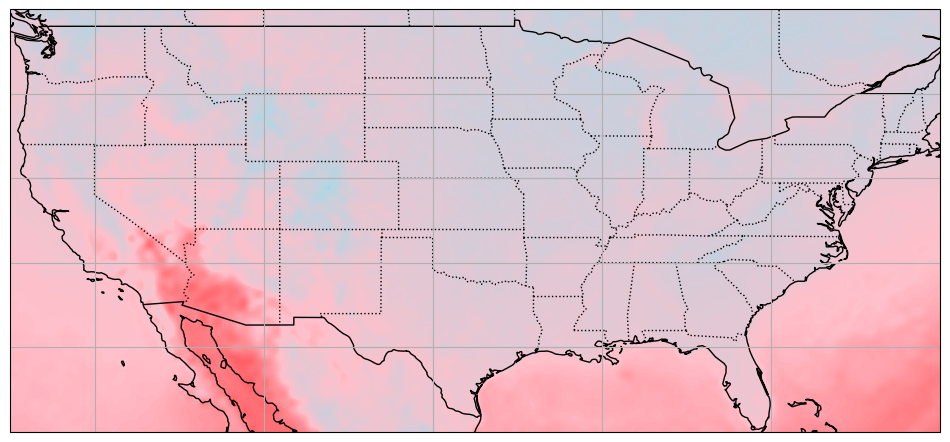

In [74]:
# Create a custom colormap transitioning from blue to orange to red
normalized_colors = [(r/255, g/255, b/255) for (r, g, b) in [(0, 0, 128), (0, 0, 255), (173, 216, 230), (255, 192, 203), (255, 0, 0)]]
cmap_custom = LinearSegmentedColormap.from_list('custom', normalized_colors, N=256)
#cmap_custom = plt.cm.rainbow  # Using built-in rainbow colormap

# Add state boundaries feature
states_provinces = NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none',
    edgecolor='black'
)

init_date = datetime.strptime("2023-10-16 12", "%Y-%m-%d %H")

# Choose the correct amount of runs
fxx_range = range(0, 30, 6)

# Function to get data for a specific run time and forecast hour
def get_data(init_date, fxx):
    try:
        H = Herbie(
            init_date.strftime("%Y-%m-%d %H"),
            model="ecmwf",
            product="oper",
            fxx=fxx
        )
        
        ds = H.xarray(":2t:")
        
        # Check if valid_time has duplicates and deduplicate if necessary
        if 'valid_time' in ds.coords and ds['valid_time'].size > 1:
            _, index = np.unique(ds['valid_time'], return_index=True)
            ds = ds.isel(valid_time=index)
        
        return ds['t2m'].values, ds['longitude'].values, ds['latitude'].values
    except:
        return None, None, None

# Define the update function for animation
def update(*args):
    t2m_data, lon, lat = args
    if t2m_data is not None:
        t2m_data_smooth = zoom(t2m_data, 2)  # Smoothing the data
        
        ax.clear()
        ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
        ax.coastlines()
        ax.gridlines()
        ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
        ax.add_feature(states_provinces, linestyle=':', edgecolor='black')
        
        ax.imshow(t2m_data_smooth, extent=[lon.min(), lon.max(), lat.min(), lat.max()], origin='upper', cmap=cmap_custom, transform=ccrs.PlateCarree(), interpolation='bilinear')  # Added interpolation
        
        ax.set_extent([-125, -70, 25, 50], crs=ccrs.PlateCarree())
    return ax,

    
# Initialize plot with larger size
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 8))
ax.coastlines()
ax.gridlines()

# Create and display animation
ani = FuncAnimation(fig, lambda x: update(*get_data(init_date, x)), frames=fxx_range, blit=False)
HTML(ani.to_jshtml())